# What is this?



In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

from pathlib import Path

In [2]:
def combine_configuration_results_to_df(path):
    dfs = []
    for csv_file in Path(path).glob("*.csv"):
        stem = csv_file.stem
        _, computer, os, python_version = stem.split("_")
        python_version = python_version.replace("python", "")
        
        df = pd.read_csv(csv_file, usecols=("Min", "Max", "Average", "Duration", "Energy consumption"))
        df.rename(columns={"Min": "P_min", "Max": "P_max", "Average": "P_mean", "Duration": "t_run", "Energy consumption": "E"}, inplace=True)

        df["Computer"] = computer
        df["OS"] = os
        df["Python_version"] = python_version

        dfs.append(df)

    return pd.concat(dfs, axis=0, ignore_index=True)


df = combine_configuration_results_to_df("results")
df

,P_min,P_max,P_mean,t_run,E,Computer,OS,Python_version
0,2.17208,4.61929,2.75407,291.520,802.86692,RPi4B,FreeBSD,3.12
1,2.17860,4.33274,2.75425,290.893,801.19187,RPi4B,FreeBSD,3.12
2,2.17015,4.29701,2.75501,281.854,776.51185,RPi4B,FreeBSD,3.12
3,2.17166,4.34122,2.75492,282.026,776.96013,RPi4B,FreeBSD,3.12
4,2.17207,4.16131,2.75386,290.961,801.26496,RPi4B,FreeBSD,3.12
...,...,...,...,...,...,...,...,...
395,1.95921,3.35414,2.33557,1248.579,2916.14263,RPi3B+,Alpine,3.10
396,1.95587,3.30313,2.33507,1248.970,2916.43470,RPi3B+,Alpine,3.10
397,1.95763,3.38293,2.33552,1248.023,2914.78164,RPi3B+,Alpine,3.10
398,1.96758,3.30020,2.33456,1248.337,2914.31565,RPi3B+,Alpine,3.10


In [3]:
df.to_csv("/tmp/analysis.csv", index=False)

In [4]:
df.t_run = pd.to_timedelta(df.t_run, unit="s")

In [20]:
df.t_run

0     0 days 00:04:51.520000
1     0 days 00:04:50.893000
2     0 days 00:04:41.854000
3     0 days 00:04:42.026000
4     0 days 00:04:50.961000
               ...          
395   0 days 00:20:48.579000
396   0 days 00:20:48.970000
397   0 days 00:20:48.023000
398   0 days 00:20:48.337000
399   0 days 00:20:47.077000
Name: t_run, Length: 400, dtype: timedelta64[ns]

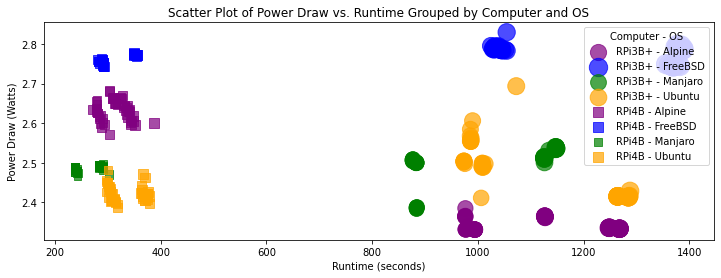

In [5]:
df['t_run_seconds'] = df['t_run'].dt.total_seconds()
grouped_df = df.groupby(['Computer', 'OS'])

# Define markers and colors
markers = {'RPi3B+': 'o', 'RPi4B': 's'}
palette = {'FreeBSD': 'blue', 'Manjaro': 'green', 'Ubuntu': 'orange', 'Alpine': 'purple'}

# Create the scatter plot
plt.figure(figsize=(12, 4))

for (computer, os), group in grouped_df:
    plt.scatter(group['t_run_seconds'], 
                group['P_mean'], 
                label=f'{computer} - {os}', 
                marker=markers[computer], 
                color=palette[os], 
                s=group.E / 10, alpha=0.7)
    
    y_data = group['P_mean']
    x_data = group['t_run_seconds']
    x_q1, x_median, x_q3 = np.percentile(x_data, [25, 50, 75])
    y_q1, y_median, y_q3 = np.percentile(y_data, [25, 50, 75])
    #plt.boxplot(y_data, positions=[x_median], widths=x_q3 - x_q1,
    #            showbox=True, manage_ticks=False)
    #plt.boxplot(x_data, positions=[y_median], vert=False,
    #            showbox=True, manage_ticks=False)
    #plt.gca().add_patch(plt.Rectangle((x_q1, y_q1), x_q3 - x_q1, y_q3 - y_q1,
    #                                  edgecolor='black'))
    
plt.xlabel('Runtime (seconds)')
plt.ylabel('Power Draw (Watts)')
plt.title('Scatter Plot of Power Draw vs. Runtime Grouped by Computer and OS')
plt.legend(title='Computer - OS')
plt.show()

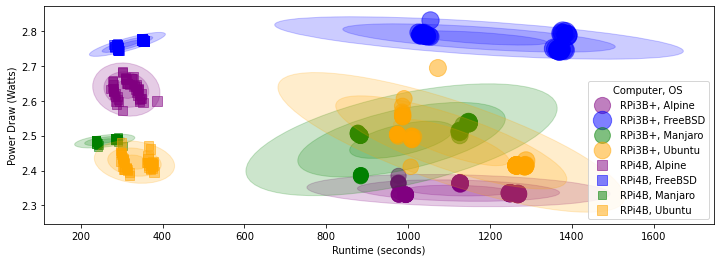

In [103]:
df["t_run_seconds"] = df["t_run"].dt.total_seconds()

grouped_df = df.groupby(["Computer", "OS"])

markers = {"RPi3B+": "o", "RPi4B": "s"}
palette = {"FreeBSD": "blue", "Manjaro": "green", "Ubuntu": "orange", "Alpine": "purple"}

def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        for nsig in range(1, 4):
            ax.add_patch(Ellipse(xy=position,
                                 width=nsig * width,
                                 height=nsig * height,
                                 angle=angle,
                                 **kwargs))

plt.figure(figsize=(12, 4))

for (computer, os), group in grouped_df:
    plt.scatter(group["t_run_seconds"], 
                group["P_mean"],
                label=f"{computer}, {os}",
                marker=markers[computer],
                color=palette[os],
                s=group.E / 10, alpha=0.5)

    cov = np.cov(group["t_run_seconds"], group["P_mean"])
    mean = [group["t_run_seconds"].mean(), group["P_mean"].mean()]

    draw_ellipse(mean, cov, plt.gca(),
                 edgecolor=palette[os],
                 facecolor=palette[os],
                 alpha=0.2)

plt.xlabel("Runtime (seconds)")
plt.ylabel("Power Draw (Watts)")
#plt.title("Bagplot of Power Draw vs. Runtime Grouped by Computer and OS")
plt.legend(title="Computer, OS")
plt.savefig("report_source/images/P_t_E_bagplot.pdf", bbox_inches="tight")
plt.show()


In [110]:
df[df.Computer == "RPi3B+"].t_run_seconds.describe()

count     200.000000
mean     1096.041265
std       155.793118
min       876.027000
25%       984.180000
50%      1042.143500
75%      1253.093750
max      1388.549000
Name: t_run_seconds, dtype: float64

In [111]:
df[df.Computer == "RPi4B"].t_run_seconds.describe()

count    200.000000
mean     303.954615
std       39.659607
min      237.130000
25%      283.862500
50%      297.505000
75%      338.595250
max      386.519000
Name: t_run_seconds, dtype: float64

In [117]:
df[df.t_run == df.t_run.min()]

,P_min,P_max,P_mean,t_run,E,Computer,OS,Python_version,t_run_seconds
69,1.56607,4.02517,2.48866,0 days 00:03:57.130000,590.13487,RPi4B,Manjaro,3.11,237.13


In [118]:
df[df.t_run == df.t_run.max()]

,P_min,P_max,P_mean,t_run,E,Computer,OS,Python_version,t_run_seconds
39,2.36925,3.65813,2.78762,0 days 00:23:08.549000,3870.74478,RPi3B+,FreeBSD,3.10,1388.549


In [131]:
df.groupby(["Computer", "OS"]).t_run.describe().sort_values("mean")

count                    mean                        std  \
Computer OS                                                                 
RPi4B    Manjaro    50  0 days 00:04:18.764540  0 days 00:00:24.500378512   
         Alpine     50  0 days 00:05:11.532460  0 days 00:00:27.376475347   
         FreeBSD    50  0 days 00:05:14.141560  0 days 00:00:30.914348344   
         Ubuntu     50  0 days 00:05:31.379900  0 days 00:00:32.658799132   
RPi3B+   Manjaro    50  0 days 00:16:23.611000  0 days 00:02:06.689637005   
         Ubuntu     50  0 days 00:18:24.983500  0 days 00:02:21.074040323   
         Alpine     50  0 days 00:18:42.714040  0 days 00:02:03.402915467   
         FreeBSD    50  0 days 00:19:32.856520  0 days 00:02:46.326407315   

                                     min                     25%  \
Computer OS                                                        
RPi4B    Manjaro  0 days 00:03:57.130000  0 days 00:03:58.016000   
         Alpine   0 days 00:04:31.348000  0 days 00:04:44.346500   
         FreeBSD  0 days 00:04:39.835000  0 days 00:04:49.835000   
         Ubuntu   0 days 00:04:56.699000  0 days 00:05:04.004250   
RPi3B+   Manjaro  0 days 00:14:36.027000  0 days 00:14:42.945750   
         Ubuntu   0 days 00:16:12.961000  0 days 00:16:25.710250   
         Alpine   0 days 00:16:15.692000  0 days 00:16:33.950000   
         FreeBSD  0 days 00:17:04.547000  0 days 00:17:16.906250   

                                     50%                     75%  \
Computer OS                                                        
RPi4B    Manjaro  0 days 00:04:01.297500  0 days 00:04:43.953500   
         Alpine   0 days 00:05:11.022000  0 days 00:05:35.622750   
         FreeBSD  0 days 00:04:51.451000  0 days 00:05:49.364000   
         Ubuntu   0 days 00:05:12.449500  0 days 00:06:06.447250   
RPi3B+   Manjaro  0 days 00:14:44.006000  0 days 00:18:45.796750   
         Ubuntu   0 days 00:16:48.746000  0 days 00:21:04.669500   
         Alpine   0 days 00:18:46.807500  0 days 00:20:48.711750   
         FreeBSD  0 days 00:17:25.647500  0 days 00:22:49.918750   

                                     max  
Computer OS                               
RPi4B    Manjaro  0 days 00:05:02.387000  
         Alpine   0 days 00:06:26.519000  
         FreeBSD  0 days 00:05:54.468000  
         Ubuntu   0 days 00:06:18.972000  
RPi3B+   Manjaro  0 days 00:19:08.303000  
         Ubuntu   0 days 00:21:27.579000  
         Alpine   0 days 00:21:08.393000  
         FreeBSD  0 days 00:23:08.549000

In [134]:
df.groupby(["Computer", "OS", "Python_version"]).t_run.describe().sort_values("mean")

count                    mean  \
Computer OS      Python_version                                 
RPi4B    Manjaro 3.11              10  0 days 00:03:58.045200   
                 3.12              10  0 days 00:03:58.048600   
                 3.13              10  0 days 00:04:01.346600   
         Alpine  3.12              10  0 days 00:04:39.479000   
         Manjaro 3.10              10  0 days 00:04:44.602700   
         Alpine  3.11              10  0 days 00:04:47.336900   
         FreeBSD 3.11              10  0 days 00:04:47.828200   
                 3.12              10  0 days 00:04:48.541300   
                 3.13              10  0 days 00:04:51.439700   
         Manjaro 3.9               10  0 days 00:04:51.779600   
         Ubuntu  3.13              10  0 days 00:05:01.268200   
                 3.12              10  0 days 00:05:03.486100   
         Alpine  3.13              10  0 days 00:05:10.597900   
         Ubuntu  3.11              10  0 days 00:05:11.424300   
         Alpine  3.10              10  0 days 00:05:35.016200   
                 3.9               10  0 days 00:05:45.232300   
         FreeBSD 3.9               10  0 days 00:05:49.097200   
                 3.10              10  0 days 00:05:53.801400   
         Ubuntu  3.10              10  0 days 00:06:09.050600   
                 3.9               10  0 days 00:06:11.670300   
RPi3B+   Manjaro 3.11              10  0 days 00:14:36.708300   
                 3.12              10  0 days 00:14:43.367700   
                 3.13              10  0 days 00:14:44.069900   
         Ubuntu  3.12              10  0 days 00:16:13.664000   
         Alpine  3.12              10  0 days 00:16:16.837300   
         Ubuntu  3.13              10  0 days 00:16:26.624400   
         Alpine  3.11              10  0 days 00:16:34.113600   
         Ubuntu  3.11              10  0 days 00:16:55.198300   
         FreeBSD 3.13              10  0 days 00:17:12.959600   
                 3.11              10  0 days 00:17:17.809600   
                 3.12              10  0 days 00:17:24.970400   
         Manjaro 3.10              10  0 days 00:18:46.360700   
         Alpine  3.13              10  0 days 00:18:46.655200   
         Manjaro 3.9               10  0 days 00:19:07.548400   
         Alpine  3.10              10  0 days 00:20:48.302200   
         Ubuntu  3.10              10  0 days 00:21:04.343000   
         Alpine  3.9               10  0 days 00:21:07.661900   
         Ubuntu  3.9               10  0 days 00:21:25.087800   
         FreeBSD 3.9               10  0 days 00:22:46.896000   
                 3.10              10  0 days 00:23:01.647000   

                                                       std  \
Computer OS      Python_version                              
RPi4B    Manjaro 3.11            0 days 00:00:02.256095437   
                 3.12            0 days 00:00:00.185868053   
                 3.13            0 days 00:00:00.445081315   
         Alpine  3.12            0 days 00:00:03.453242019   
         Manjaro 3.10            0 days 00:00:02.253444624   
         Alpine  3.11            0 days 00:00:07.718968935   
         FreeBSD 3.11            0 days 00:00:02.844195953   
                 3.12            0 days 00:00:04.252799497   
                 3.13            0 days 00:00:01.102270691   
         Manjaro 3.9             0 days 00:00:03.730470247   
         Ubuntu  3.13            0 days 00:00:04.264312626   
                 3.12            0 days 00:00:02.358975034   
         Alpine  3.13            0 days 00:00:05.206332521   
         Ubuntu  3.11            0 days 00:00:05.678881346   
         Alpine  3.10            0 days 00:00:07.359170753   
                 3.9             0 days 00:00:16.125487024   
         FreeBSD 3.9             0 days 00:00:00.366931964   
                 3.10            0 days 00:00:00.473484999   
         Ubuntu  3.10            0 days 00:00:05.337205806   

In [114]:
df[df.P_mean == df.P_mean.max()]

,P_min,P_max,P_mean,t_run,E,Computer,OS,Python_version,t_run_seconds
47,2.36342,3.95478,2.82978,0 days 00:17:34.322000,2983.49772,RPi3B+,FreeBSD,3.13,1054.322


In [119]:
df[df.P_mean == df.P_mean.min()]

,P_min,P_max,P_mean,t_run,E,Computer,OS,Python_version,t_run_seconds
280,1.95567,3.30943,2.32994,0 days 00:16:33.778000,2315.44484,RPi3B+,Alpine,3.11,993.778


In [116]:
df.P_mean.describe()

count    400.000000
mean       2.549033
std        0.152123
min        2.329940
25%        2.419840
50%        2.500585
75%        2.705672
max        2.829780
Name: P_mean, dtype: float64

In [124]:
df[df.Computer == "RPi3B+"].E.describe()

count     200.000000
mean     2768.108704
std       459.245096
min      2106.120020
25%      2401.196435
50%      2866.209665
75%      2955.146102
max      3870.744780
Name: E, dtype: float64

In [123]:
df[df.Computer == "RPi4B"].E.describe()

count     200.000000
mean      783.407843
std       113.145325
min       589.260810
25%       724.876775
50%       774.543220
75%       883.103482
max      1004.874850
Name: E, dtype: float64

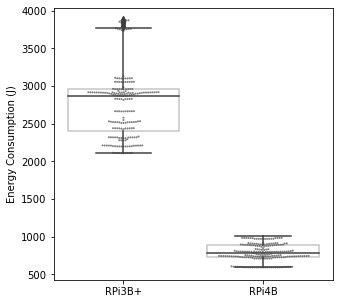

In [145]:
plt.figure(figsize=(5, 5))

df2 = df.sort_values("Computer")
p1 = sns.boxplot(data=df2, x="Computer", y="E", boxprops={"facecolor": "None", "alpha": 0.3})
p2 = sns.swarmplot(data=df2, x="Computer", y="E", zorder=.5, s=2, color="gray")

plt.xlabel("")
plt.ylabel('Energy Consumption (J)')
#plt.title('Energy Consumption by Computer')

plt.savefig("report_source/images/E_per_SUT.pdf", bbox_inches="tight")
plt.show()

In [298]:
marker_dict = {
    "Alpine": "H",
    "FreeBSD": "v",
    "Manjaro": "s",
    "Ubuntu": "o"
}
color_dict = { v: sns.color_palette("colorblind")[idx] for idx, v in enumerate(["3.9", "3.10", "3.11", "3.12", "3.13"]) }
fillstyle_dict = {
    "RPi3B+": ("P", sns.color_palette("colorblind")[5]),
    "RPi4B": ("X", sns.color_palette("colorblind")[8]),
}

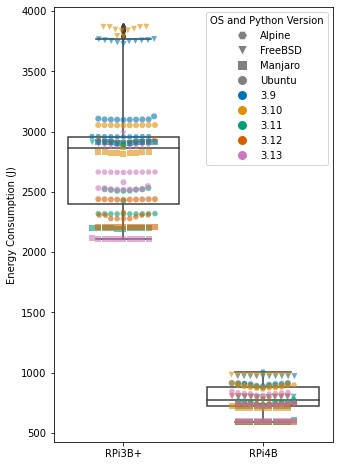

In [316]:
plt.figure(figsize=(5, 8))
df2 = df.sort_values("Computer")

sns.boxplot(data=df2, x="Computer", y="E", boxprops={"facecolor": "None"})
for os, marker in marker_dict.items():
    for version, color in color_dict.items():
        subset = df2[(df2["OS"] == os) & (df2["Python_version"] == version)]
        sns.swarmplot(data=subset, x="Computer", y="E", marker=marker, color=color, s=6, alpha=0.6)

plt.xlabel("")
plt.ylabel("Energy Consumption (J)")
#plt.title("Energy Consumption by Computer with OS and Python Version")

os_handles = [plt.Line2D([0], [0], marker=marker_dict[os], color="w", markerfacecolor="gray", markersize=10, label=os) for os in marker_dict.keys()]
python_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_dict[v], markersize=10, label=v) for v in color_dict.keys()]

plt.legend(handles=os_handles + python_handles, title="OS and Python Version", loc="upper right") #, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.savefig("report_source/images/E_per_SUT.pdf", bbox_inches="tight")
plt.show()

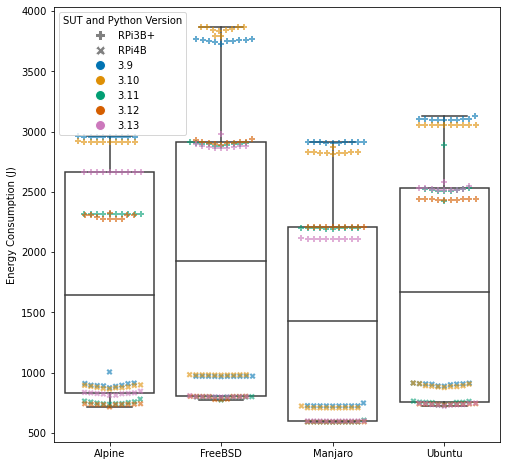

In [317]:
df2 = df.sort_values("OS")

plt.figure(figsize=(8, 8))

sns.boxplot(data=df2, x="OS", y="E", boxprops={"facecolor": "None"})
for computer, fillstyle in fillstyle_dict.items():
    for version, color in color_dict.items():
        subset = df2[(df2["Computer"] == computer) & (df2["Python_version"] == version)]        
        sns.swarmplot(data=subset, x="OS", y="E", color=color, s=6, alpha=0.6,
                      marker=fillstyle_dict[computer][0])

# p2 = sns.swarmplot(data=df2, x="OS", y="E", hue="Computer", zorder=.5, s=6)

plt.xlabel("")
plt.ylabel('Energy Consumption (J)')
#plt.title('Energy Consumption by Operating System')

computer_handles = [plt.Line2D([0], [0], marker=fillstyle_dict[c][0], color="w", markerfacecolor="gray", markersize=10, label=c) for c in fillstyle_dict.keys()]
python_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_dict[v], markersize=10, label=v) for v in color_dict.keys()]

plt.legend(handles=computer_handles + python_handles, title="SUT and Python Version", loc="upper left") #, bbox_to_anchor=(1.05, 1), loc="upper left")


plt.savefig("report_source/images/E_per_OS.pdf", bbox_inches="tight")
plt.show()

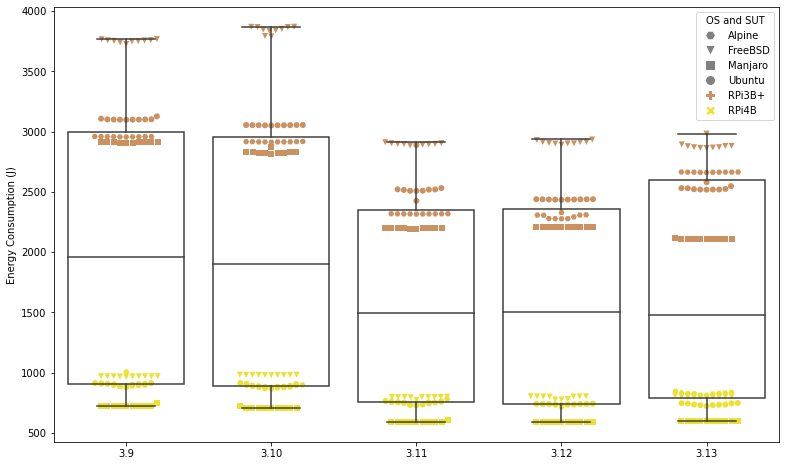

In [318]:
df2["minor_version"] = df.Python_version.apply(lambda v: int(v.split(".")[-1]))
df2 = df2.sort_values("minor_version")

plt.figure(figsize=(13, 8))

sns.boxplot(data=df2, x="Python_version", y="E", boxprops={"facecolor": "None"})
for computer, fillstyle in fillstyle_dict.items():
    for os, marker in marker_dict.items():
        subset = df2[(df2["OS"] == os) & (df2["Computer"] == computer)]
        sns.swarmplot(data=subset, x="Python_version", y="E", zorder=.5, s=6, marker=marker, color=fillstyle[1])

plt.xlabel("")
plt.ylabel('Energy Consumption (J)')
#plt.title('Energy Consumption by Computer')


os_handles = [plt.Line2D([0], [0], marker=marker_dict[os], color="w", markerfacecolor="gray", markersize=10, label=os) for os in marker_dict.keys()]
computer_handles = [plt.Line2D([0], [0], marker=fillstyle_dict[c][0], color="w", markerfacecolor=fillstyle_dict[c][1], markersize=10, label=c) for c in fillstyle_dict.keys()]

plt.legend(handles=os_handles + computer_handles, title="OS and SUT") #, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.savefig("report_source/images/E_per_Python_version.pdf", bbox_inches="tight")
plt.show()

In [136]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Fit the linear model with categorical variables
model = ols('E ~ C(Computer) + C(OS) + C(Python_version)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_table)


                         sum_sq     df             F         PR(>F)
C(Computer)        3.939038e+08    1.0  10519.470772  9.674120e-285
C(OS)              1.373431e+07    3.0    122.261361   7.275803e-56
C(Python_version)  1.614250e+07    4.0    107.774113   8.282621e-62
Residual           1.464108e+07  391.0           NaN            NaN


In [137]:
# Fit the linear model with three-way interaction
model = ols('E ~ C(Computer) * C(OS) * C(Python_version)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_table)


                                           sum_sq     df              F  \
C(Computer)                          3.939038e+08    1.0  727505.574764   
C(OS)                                1.373431e+07    3.0    8455.351360   
C(Python_version)                    1.614250e+07    4.0    7453.442289   
C(Computer):C(OS)                    5.726876e+06    3.0    3525.678530   
C(Computer):C(Python_version)        6.671775e+06    4.0    3080.545442   
C(OS):C(Python_version)              1.307328e+06   12.0     201.209984   
C(Computer):C(OS):C(Python_version)  7.401768e+05   12.0     113.920116   
Residual                             1.949199e+05  360.0            NaN   

                                            PR(>F)  
C(Computer)                           0.000000e+00  
C(OS)                                 0.000000e+00  
C(Python_version)                     0.000000e+00  
C(Computer):C(OS)                    2.024347e-266  
C(Computer):C(Python_version)        6.379362e-277  
C(OS):

/home/ropf/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ropf/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ropf/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ropf/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ropf/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iterite

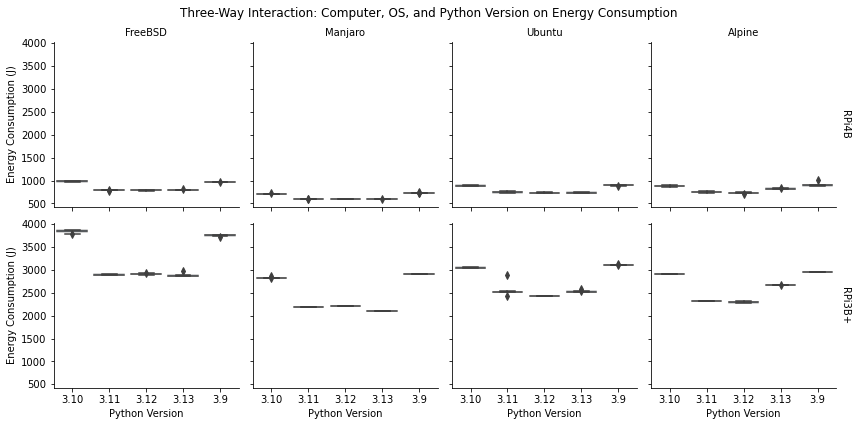

In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create a FacetGrid to visualize the three-way interaction
g = sns.FacetGrid(df, row='Computer', col='OS', margin_titles=True)
g.map(sns.boxplot, 'Python_version', 'E', order=sorted(df['Python_version'].unique()), boxprops=dict(alpha=0.3))
#g.map(sns.swarmplot, 'Python_version', 'E', order=sorted(df['Python_version'].unique()), color='black', alpha=0.6)

# Set the axis labels and title
g.set_axis_labels('Python Version', 'Energy Consumption (J)')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Three-Way Interaction: Computer, OS, and Python Version on Energy Consumption')

# Show the plot
plt.show()
